In [1]:

# importing google drive
from google.colab import drive
drive.mount('/content/drive')
     
  # This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os

#required libraries
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL


Mounted at /content/drive


In [3]:

classes_types=['M', 'B','N']
data_dir = '/content/drive/MyDrive/data/Breast Cancer Dataset'
train_dir = os.path.join(data_dir)

     

In [4]:
train_data = []
for defects_id, sp in enumerate(classes_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'Class ID','Class Type'])
train.head()


,File,Class ID,Class Type
0,M/mdb130.pgm,0,M
1,M/mdb124.pgm,0,M
2,M/mdb110.pgm,0,M
3,M/mdb102.pgm,0,M
4,M/mdb058.pgm,0,M


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()
     

,File,Class ID,Class Type
0,N/mdb098.pgm,2,N
1,N/mdb038.pgm,2,N
2,N/mdb146.pgm,2,N
3,M/mdb072.pgm,0,M
4,B/mdb227.pgm,1,B


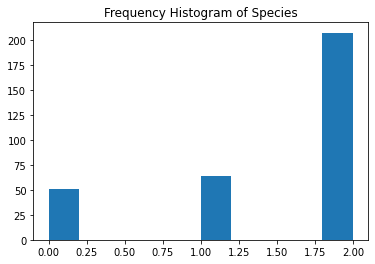

<Figure size 864x864 with 0 Axes>

In [6]:

plt.hist(train['Class ID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [7]:

IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
    

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))
     

322it [00:46,  6.96it/s]

Train Shape: (322, 224, 224, 3)


In [9]:
Y_train = train['Class ID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [10]:

BATCH_SIZE = 64
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)
     

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [15]:
from keras.layers import Dense, Flatten
from keras.models import Sequential

def create_ResNet101_CNN(input_shape=(224, 224, 3), num_classes=3):
    # Load the ResNet101 model pre-trained on ImageNet
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers so that they're not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model using the ResNet101 base and additional layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with categorical cross-entropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create a ResNet101-based CNN with default input shape (224x224x3) and 3 output classes
model = create_ResNet101_CNN()

# Train the model on your data for 50 epochs
hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50)


171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/50
9/9 [==============================] - 77s 8s/step - loss: 9.8084 - accuracy: 0.4514 - val_loss: 2.7936 - val_accuracy: 0.5538
Epoch 2/50
9/9 [==============================] - 78s 9s/step - loss: 2.3512 - accuracy: 0.4864 - val_loss: 2.7795 - val_accuracy: 0.1231
Epoch 3/50
9/9 [==============================] - 77s 9s/step - loss: 2.6084 - accuracy: 0.3619 - val_loss: 1.2706 - val_accuracy: 0.7231
Epoch 4/50
9/9 [==============================] - 79s 9s/step - loss: 1.4358 - accuracy: 0.5681 - val_loss: 1.2128 - val_accuracy: 0.7231
Epoch 5/50
9/9 [==============================] - 70s 8s/step - loss: 1.5705 - accuracy: 0.5447 - val_loss: 3.0292 - val_accuracy: 0.1231
Epoch 6/50
9/9 [==============================] - 78s 9s/step - loss: 2.3407 - accuracy: 0.5409 - val_loss: 0.8821 - val_accuracy: 0.7077
Epoch 7/50
9/9 [==============================] - 77s 9s/step - loss: 1.3750 - accuracy: 0.5486 - val_los

3/3 [==============================] - 16s 4s/step


Text(0.5, 145.31999999999996, 'Predicted')

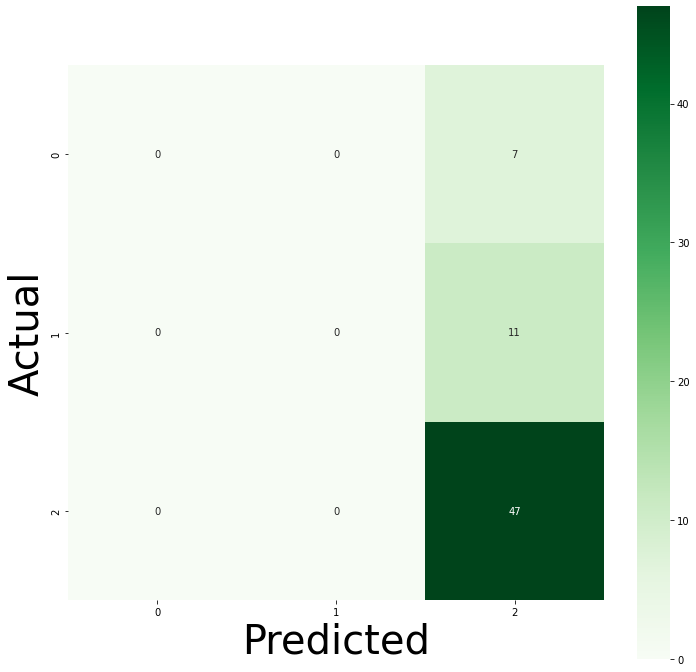

In [16]:

Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

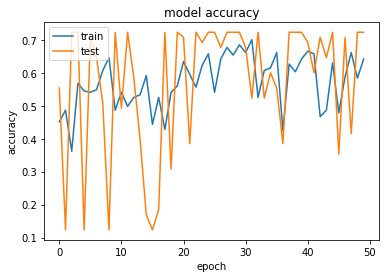

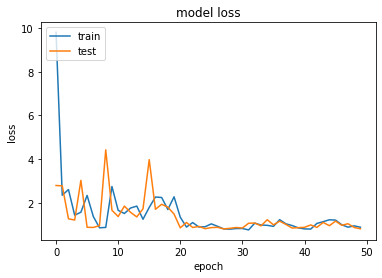

In [17]:

# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
     

1/1 [==============================] - 0s 246ms/step
[0.10470998 0.20564866 0.6896413 ]


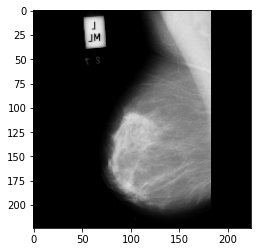

Prediction: N


In [ ]:

from skimage import io
#path='imbalanced/Scratch/Scratch_400.jpg'
import keras.utils as image
img = image.load_img('/content/drive/MyDrive/data/Breast Cancer Dataset/M/mdb095.pgm', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/data/Breast Cancer Dataset/M/mdb095.pgm', grayscale=False, target_size=(224, 224))
disease_class=['M','B','N']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255
custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])